In [1]:
import scipy.io
from scipy.stats import skew, kurtosis
from scipy.signal import stft
import numpy as np
import matplotlib.pyplot as plt
import os, shutil, time
import sys
from pathlib import Path
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
from scipy.optimize import curve_fit


In [2]:


def prepare_HI(train_time = 25):


    selected_cols =['MarginFactor', 'SKStd', 'SKSkewness', 'SKKurtosis', 'Mean']
    df = pd.read_csv("vibration_features_smooth.csv")[selected_cols]

    train_selected = df.loc[0:train_time,:] #
    test_selected = df.loc[train_time:,:] 

    scaler = StandardScaler()
    pca = PCA(n_components=2, random_state=42)
    # Normalize the values
    train_scaled = scaler.fit_transform(train_selected)
    # Apply PCA to reduce to 2D
    train_pca = pca.fit_transform(train_scaled)
    # Do the same for test data
    test_scaled = scaler.transform(test_selected)
    test_pca = pca.transform(test_scaled)
    # Do the opration on entire dataset
    full_scaled = scaler.transform(df)
    full_pca = pca.transform(full_scaled)


    # Time indices
    t_train = np.arange(train_pca.shape[0])
    t_test = np.arange(train_pca.shape[0], train_pca.shape[0] + test_pca.shape[0])
    t_full = np.arange(train_pca.shape[0] + test_pca.shape[0] - 1)

    return train_pca[:,0],test_pca[:,0],full_pca[:,0],t_train,t_test,t_full

# LSTM Model


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from IPython.display import clear_output

# --- LSTM Model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# --- Sequence Creation Helper ---
def create_sequences(data, lag):
    xs, ys = [], []
    for i in range(len(data) - lag):
        x = data[i:i+lag]
        y = data[i+lag]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# --- Main Evaluation + Plot Function ---
def train_and_evaluate_lstm(train_time, full_hi, t_full, lag_window_len=5, epochs=300, lr=0.01, do_plotting=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_hi, test_hi = full_hi[0:train_time], full_hi[train_time:]
    t_train, t_test = t_full[0:train_time], t_full[train_time:]

    # Create sequences
    X_train, y_train = create_sequences(train_hi, lag_window_len)
    if len(X_train) == 0:
        print("Training set too small.")
        return None, None

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)

    # Initialize model, loss, optimizer
    model = LSTMModel().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    # Predict training data
    model.eval()
    with torch.no_grad():
        train_pred = []
        for i in range(len(t_train) - lag_window_len):
            input_seq = torch.tensor(train_hi[i:i+lag_window_len], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            pred = model(input_seq)
            train_pred.append(pred.item())
        train_pred = [np.nan]*lag_window_len + train_pred

    # Predict test data
    test_pred = []
    last_window = train_hi[-lag_window_len:]
    for _ in range(len(t_test)):
        input_seq = torch.tensor(last_window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
        pred = model(input_seq)
        pred_value = pred.item()
        test_pred.append(pred_value)
        last_window = np.roll(last_window, -1)
        last_window[-1] = pred_value

    # Convert to numpy
    train_pred = np.array(train_pred)
    test_pred = np.array(test_pred)

    # Evaluate and compute prediction interval
    residuals = train_hi[lag_window_len:] - train_pred[lag_window_len:]
    std_error = np.std(residuals)

    ci_upper = test_pred + 1.96 * std_error
    ci_lower = test_pred - 1.96 * std_error

    train_mse = mean_squared_error(train_hi[lag_window_len:], train_pred[lag_window_len:])
    test_mse = mean_squared_error(test_pred, test_hi)
    test_mae = mean_absolute_error(test_hi, test_pred)
    test_r2 = r2_score(test_hi, test_pred)


    if do_plotting:
        plt.figure(figsize=(12, 6))
        plt.plot(t_train, train_hi, label='Train HI (True)', color='blue')
        plt.plot(t_train, train_pred, label='Fitted Train Curve', color='cyan', linestyle='--')

        plt.plot(t_test, test_hi, label='Test HI (True)', color='orange')
        plt.plot(t_test, test_pred, label='Predicted HI', color='red', linestyle='--')

        plt.fill_between(t_test, ci_lower, ci_upper, color='green', alpha=0.2, label='95% Prediction Interval')

        plt.xlabel('Time Index')
        plt.ylabel('Health Indicator (HI)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        clear_output(wait=True)
        plt.show()

    return train_mse, (test_mse, test_mae, test_r2), {'test_pred': test_pred, 'ci_lower': ci_lower, 'ci_upper': ci_upper}


In [4]:
# Assuming full_hi and t_full are available from prepapre_HI:
train_time = 35
train_hi, test_hi, full_hi, t_train, t_test, t_full = prepare_HI(train_time=train_time)
train_mse, test_metrices, predictions= train_and_evaluate_lstm(train_time, full_hi, t_full)

print(f"Timestep: {train_time} || Train MSE: {train_mse:.4f} || Test MSE: {test_metrices[0]:.4f} || Test MAE: {test_metrices[1]:.4f} || Test R2: {test_metrices[2]:.4f}")


Timestep: 35 || Train MSE: 0.1264 || Test MSE: 4.5251 || Test MAE: 1.8384 || Test R2: -2.0137


# ARIMA Model

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

def train_and_evaluate_arima(train_time, full_hi, t_full, arima_order=(5,1,0),do_plotting=False):
    train_hi, test_hi = full_hi[0:train_time], full_hi[train_time:]
    t_train, t_test = t_full[0:train_time], t_full[train_time:]

    if len(train_hi) < max(arima_order):  # Ensure enough data
        print("Training set too small for ARIMA model.")
        return None, None

    # Train ARIMA model
    model = ARIMA(train_hi, order=arima_order)
    model_fit = model.fit()

    # Predict on training data (in-sample)
    train_pred = model_fit.predict(start=0, end=len(train_hi)-1, dynamic=False)

    # Forecast on test data (out-of-sample)
    forecast_res = model_fit.get_forecast(steps=len(test_hi))
    test_pred = forecast_res.predicted_mean
    ci = forecast_res.conf_int(alpha=0.05)

    ci_lower, ci_upper = ci[:, 0], ci[:, 1]

    # Compute MSE
    train_mse = mean_squared_error(train_hi, train_pred)
    test_mse = mean_squared_error(test_hi, test_pred)
    test_mse = mean_squared_error(test_pred, test_hi)
    test_mae = mean_absolute_error(test_hi, test_pred)
    test_r2 = r2_score(test_hi, test_pred)

    if do_plotting:

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.plot(t_train, train_hi, label='Train HI (True)', color='blue')
        plt.plot(t_train, train_pred, label='Fitted Train Curve (ARIMA)', color='cyan', linestyle='--')

        plt.plot(t_test, test_hi, label='Test HI (True)', color='orange')
        plt.plot(t_test, test_pred, label='Forecasted HI', color='red', linestyle='--')

        plt.fill_between(t_test, ci_lower, ci_upper, color='green', alpha=0.2, label='95% Prediction Interval')

        plt.xlabel('Time Index')
        plt.ylabel('Health Indicator (HI)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        clear_output(wait=True)
        plt.show()

    return train_mse, (test_mse, test_mae, test_r2), {'test_pred': test_pred, 'ci_lower': ci_lower, 'ci_upper': ci_upper}


In [7]:
# Suppose prepapre_HI is already defined
train_time = 35
train_hi, test_hi, full_hi, t_train, t_test, t_full = prepare_HI(train_time=train_time)
train_mse, test_metrices, predictions = train_and_evaluate_arima(train_time, full_hi, t_full)

print(f"Timestep: {train_time} || Train MSE: {train_mse:.4f} || Test MSE: {test_metrices[0]:.4f} || Test MAE: {test_metrices[1]:.4f} || Test R2: {test_metrices[2]:.4f}")



Timestep: 35 || Train MSE: 0.5227 || Test MSE: 7.5847 || Test MAE: 2.4408 || Test R2: -4.0514


# Prophet Model

In [8]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
import time


def train_and_evaluate_prophet(train_time, full_hi, t_full,do_plotting=False):
    train_hi, test_hi = full_hi[0:train_time], full_hi[train_time:]
    t_train, t_test = t_full[0:train_time], t_full[train_time:]

    # -------- Prepare training DataFrame for Prophet --------
    df_train = pd.DataFrame({
        'ds': pd.to_datetime(t_train, unit='D'),  # Prophet needs datetime type
        'y': train_hi
    })

    # -------- Train Prophet model --------
    model = Prophet(interval_width=0.95)
    model.fit(df_train)

    # -------- Prepare future DataFrame --------
    df_future = pd.DataFrame({
        'ds': pd.to_datetime(t_test, unit='D')  # Future points (test set)
    })

    # -------- Make Predictions --------
    forecast = model.predict(df_future)

    test_pred = forecast['yhat'].values
    ci_lower = forecast['yhat_lower'].values
    ci_upper = forecast['yhat_upper'].values

    # -------- Compute metrics --------
    df_train_pred = model.predict(df_train)
    train_pred = df_train_pred['yhat'].values

    train_mse = mean_squared_error(train_hi, train_pred)
    test_mse = mean_squared_error(test_hi, test_pred)
    test_mse = mean_squared_error(test_pred, test_hi)
    test_mae = mean_absolute_error(test_hi, test_pred)
    test_r2 = r2_score(test_hi, test_pred)
    
    if do_plotting:
        # -------- Plotting --------
        plt.figure(figsize=(12, 6))

        # True HI - training
        plt.plot(t_train, train_hi, label='Train HI (True)', color='blue')
        plt.plot(t_train, train_pred, label='Fitted Train Curve', color='cyan', linestyle='--')

        # True HI - test
        plt.plot(t_test, test_hi, label='Test HI (True)', color='orange')
        plt.plot(t_test, test_pred, label='Predicted HI', color='red', linestyle='--')

        # Prediction interval
        plt.fill_between(t_test, ci_lower, ci_upper, color='green', alpha=0.2, label='95% Prediction Interval')

        plt.xlabel('Time Index')
        plt.ylabel('Health Indicator (HI)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    return train_mse, (test_mse, test_mae, test_r2), {'test_pred': test_pred, 'ci_lower': ci_lower, 'ci_upper': ci_upper}



Importing plotly failed. Interactive plots will not work.


In [9]:
train_time = 35
train_hi, test_hi, full_hi, t_train, t_test, t_full = prepare_HI(train_time=train_time)
train_mse, test_metrices, predictions = train_and_evaluate_prophet(train_time, full_hi, t_full)
print(f"Timestep: {train_time} || Train MSE: {train_mse:.4f} || Test MSE: {test_metrices[0]:.4f} || Test MAE: {test_metrices[1]:.4f} || Test R2: {test_metrices[2]:.4f}")


09:55:09 - cmdstanpy - INFO - Chain [1] start processing
09:55:09 - cmdstanpy - INFO - Chain [1] done processing


Timestep: 35 || Train MSE: 0.3061 || Test MSE: 1.3592 || Test MAE: 1.0097 || Test R2: 0.0948


# Prediction for Each Model

In [26]:
import matplotlib.pyplot as plt

def plot_model_predictions_with_ci(full_hi, t_full, model_outputs, time_step):
    """
    Plot predictions and confidence intervals of multiple models on the same plot.
    
    Parameters:
    - t_train, train_hi: Time and HI values for training
    - t_test, test_hi: Time and HI values for testing
    - model_outputs: List of tuples (model_name, predictions_dict, color)
    """
    plt.figure(figsize=(14, 6))
    
    train_hi, test_hi = full_hi[0:train_time], full_hi[train_time:]
    t_train, t_test = t_full[0:train_time], t_full[train_time:]

    # Ground truth
    plt.plot(t_train, train_hi, label='Train HI (True)', color='black', linewidth=1)
    plt.plot(t_test, test_hi, label='Test HI (True)', color='black', linewidth=1, linestyle='--')

    # Plot each model's predictions and confidence intervals
    for model_name, pred_dict, color in model_outputs:
        test_pred = pred_dict['test_pred']
        ci_lower = pred_dict['ci_lower']
        ci_upper = pred_dict['ci_upper']

        plt.plot(t_test, test_pred, label=f'{model_name} Prediction', color=color, linestyle='--')
        plt.fill_between(t_test, ci_lower, ci_upper, color=color, alpha=0.2, label=f'{model_name} 95% CI')

    plt.xlabel('Time Index')
    plt.ylabel('Health Indicator (HI)')
    plt.title(f'Model Predictions with 95% Confidence Intervals at t = {time_step}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/home/mohan.dash/miniconda3/envs/diffusion_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
10:10:16 - cmdstanpy - INFO - Chain [1] start processing
10:10:16 - cmdstanpy - INFO - Chain [1] done processing


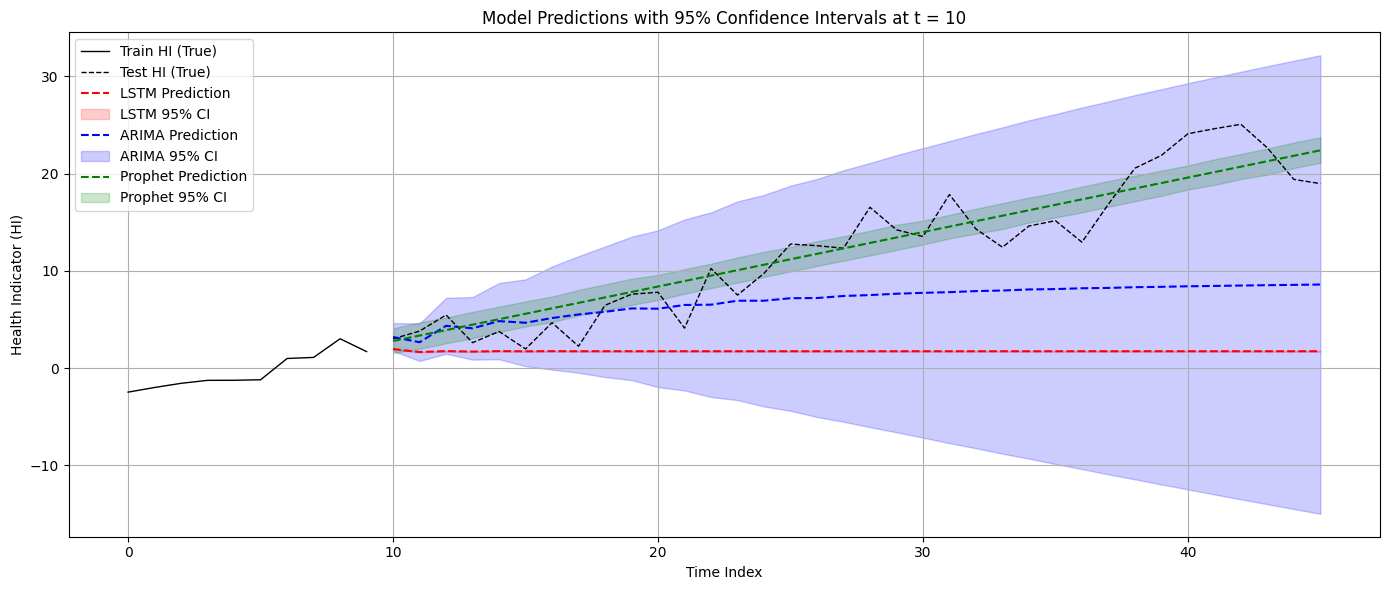

In [29]:
train_time=10

train_hi, test_hi, full_hi, t_train, t_test, t_full = prepare_HI(train_time=train_time)

_, _, pred_lstm = train_and_evaluate_lstm(train_time, full_hi, t_full)
_, _, pred_arima = train_and_evaluate_arima(train_time, full_hi, t_full)
_, _, pred_prophet = train_and_evaluate_prophet(train_time, full_hi, t_full)

model_outputs = [
    ("LSTM", pred_lstm, "red"),
    ("ARIMA", pred_arima, "blue"),
    ("Prophet", pred_prophet, "green")
]

plot_model_predictions_with_ci(full_hi, t_full, model_outputs, time_step=train_time)


/home/mohan.dash/miniconda3/envs/diffusion_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
09:59:24 - cmdstanpy - INFO - Chain [1] start processing
09:59:24 - cmdstanpy - INFO - Chain [1] done processing


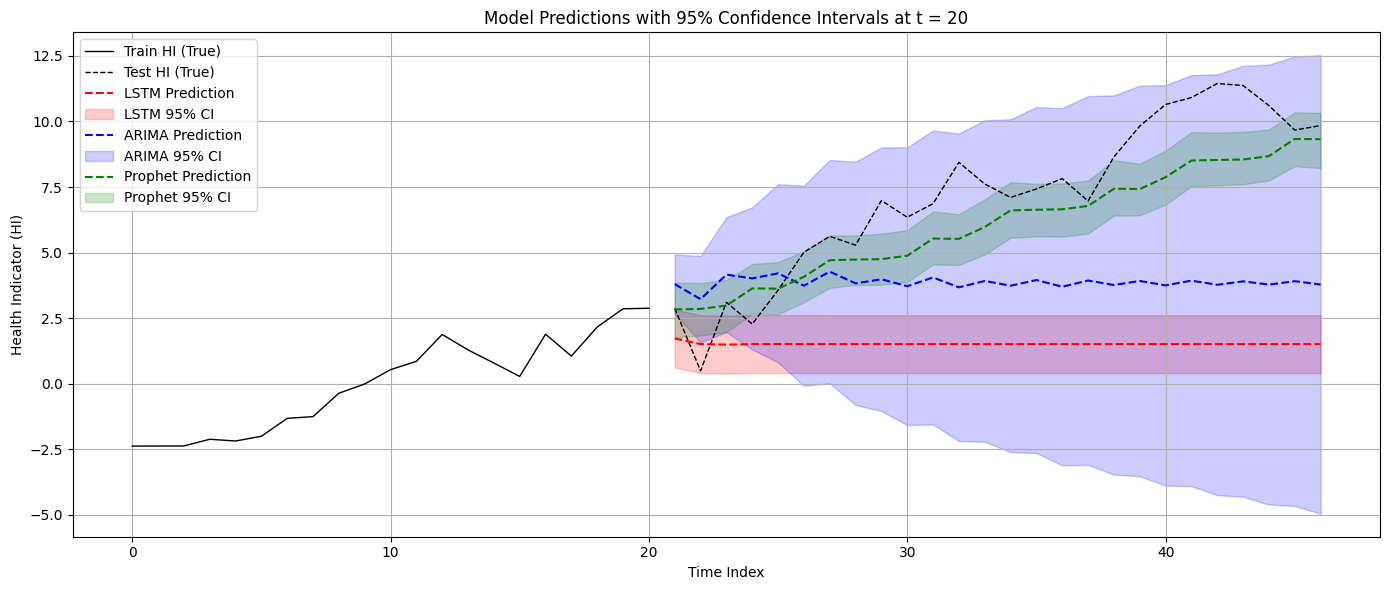

In [19]:
train_time=20

train_hi, test_hi, full_hi, t_train, t_test, t_full = prepare_HI(train_time=train_time)

_, _, pred_lstm = train_and_evaluate_lstm(train_time, full_hi, t_full)
_, _, pred_arima = train_and_evaluate_arima(train_time, full_hi, t_full)
_, _, pred_prophet = train_and_evaluate_prophet(train_time, full_hi, t_full)

model_outputs = [
    ("LSTM", pred_lstm, "red"),
    ("ARIMA", pred_arima, "blue"),
    ("Prophet", pred_prophet, "green")
]

plot_model_predictions_with_ci(t_train, train_hi, t_test, test_hi, model_outputs, time_step=train_time)

10:02:31 - cmdstanpy - INFO - Chain [1] start processing
10:02:31 - cmdstanpy - INFO - Chain [1] done processing


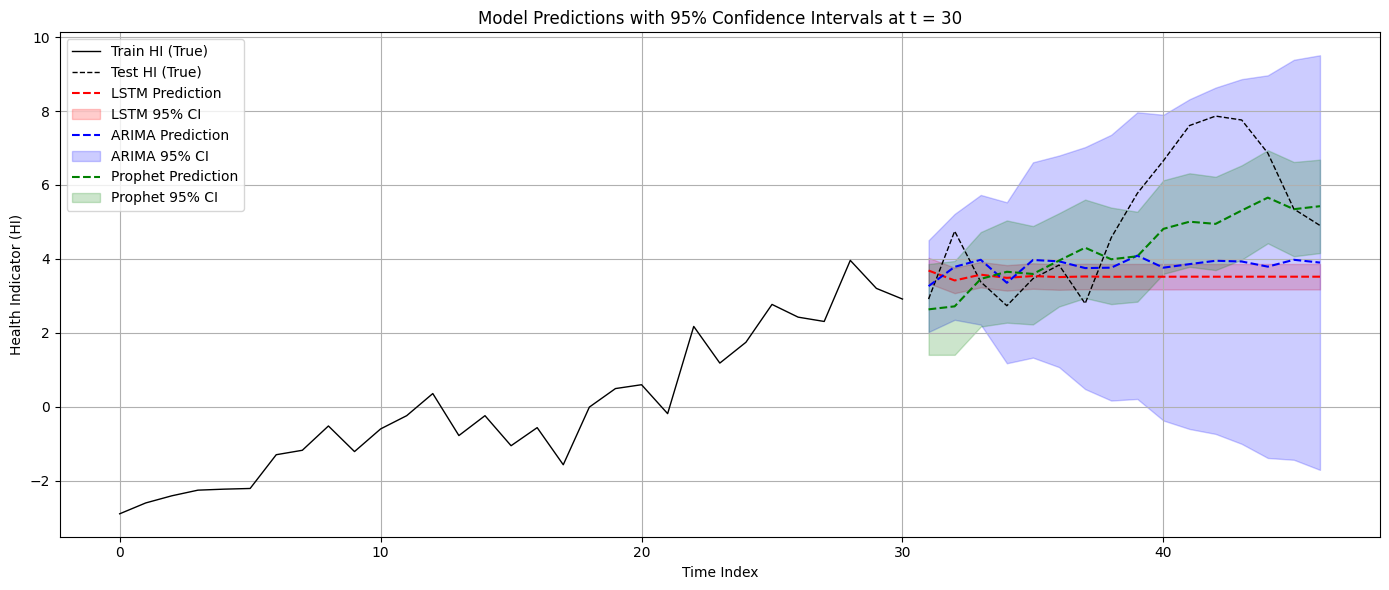

In [25]:
train_time=30

train_hi, test_hi, full_hi, t_train, t_test, t_full = prepare_HI(train_time=train_time)

_, _, pred_lstm = train_and_evaluate_lstm(train_time, full_hi, t_full)
_, _, pred_arima = train_and_evaluate_arima(train_time, full_hi, t_full)
_, _, pred_prophet = train_and_evaluate_prophet(train_time, full_hi, t_full)

model_outputs = [
    ("LSTM", pred_lstm, "red"),
    ("ARIMA", pred_arima, "blue"),
    ("Prophet", pred_prophet, "green")
]

plot_model_predictions_with_ci(t_train, train_hi, t_test, test_hi, model_outputs, time_step=train_time)

10:02:28 - cmdstanpy - INFO - Chain [1] start processing
10:02:28 - cmdstanpy - INFO - Chain [1] done processing


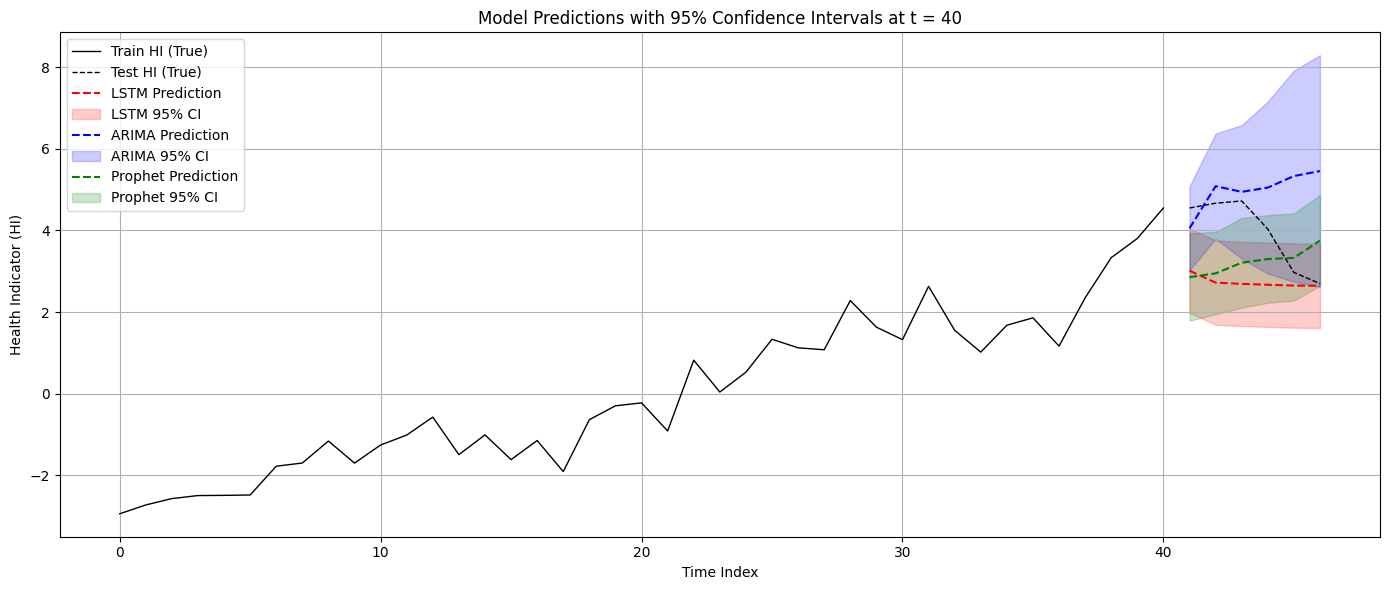

In [24]:
train_time=40

train_hi, test_hi, full_hi, t_train, t_test, t_full = prepare_HI(train_time=train_time)

_, _, pred_lstm = train_and_evaluate_lstm(train_time, full_hi, t_full)
_, _, pred_arima = train_and_evaluate_arima(train_time, full_hi, t_full)
_, _, pred_prophet = train_and_evaluate_prophet(train_time, full_hi, t_full)

model_outputs = [
    ("LSTM", pred_lstm, "red"),
    ("ARIMA", pred_arima, "blue"),
    ("Prophet", pred_prophet, "green")
]

plot_model_predictions_with_ci(t_train, train_hi, t_test, test_hi, model_outputs, time_step=train_time)

# Benchmarking

/home/mohan.dash/miniconda3/envs/diffusion_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
10:01:35 - cmdstanpy - INFO - Chain [1] start processing
10:01:35 - cmdstanpy - INFO - Chain [1] done processing
/home/mohan.dash/miniconda3/envs/diffusion_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
10:01:35 - cmdstanpy - INFO - Chain [1] start processing
10:01:35 - cmdstanpy - INFO - Chain [1] done processing
10:01:36 - cmdstanpy - INFO - Chain [1] start processing
10:01:36 - cmdstanpy - INFO - Chain [1] done processing
10:01:37 - cmdstanpy - INFO - Chain [1] start processing
10:01:37 - cmdstanpy - INFO - Chain 

,Train Time,Model,MSE,MAE,R2
0,10,LSTM,156.224,10.403,-2.26
1,10,ARIMA,60.892,6.096,-0.27
2,10,PROPHET,6.440,2.068,0.87
3,20,LSTM,39.903,5.660,-3.57
4,20,ARIMA,19.804,3.868,-1.27
5,20,PROPHET,2.814,1.381,0.68
6,30,LSTM,7.262,2.099,-1.30
7,30,ARIMA,4.453,1.652,-0.41
8,30,PROPHET,2.314,1.181,0.27
9,40,LSTM,0.721,0.713,-0.08


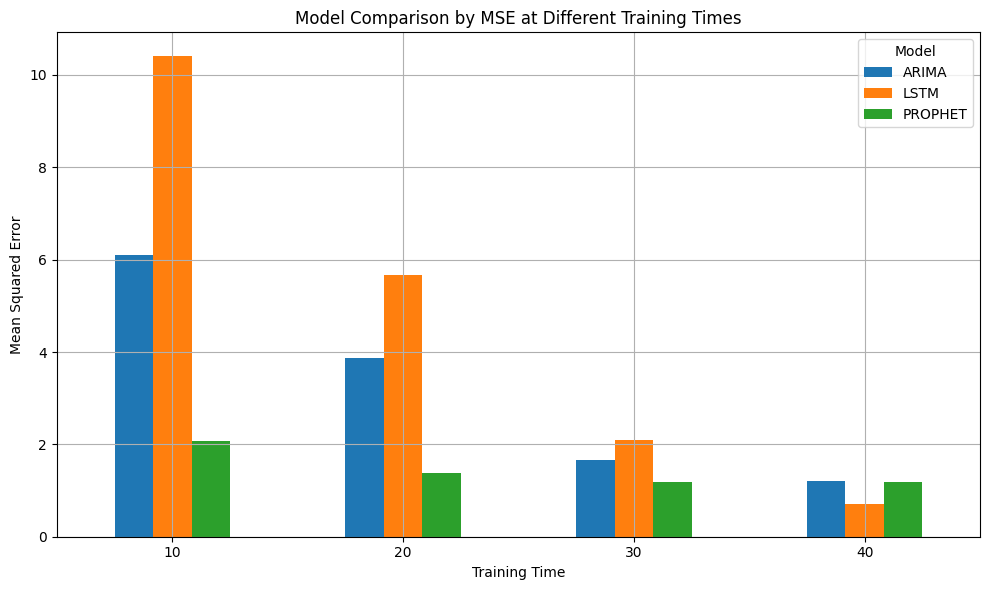

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Define the training time points for benchmarking
train_times = [10,20,30,40]

# Initialize an empty list to collect benchmark data
benchmark_data = []

# Loop through each train_time and collect metrics for all models
for train_time in train_times:
    train_hi, test_hi, full_hi, t_train, t_test, t_full = prepare_HI(train_time=train_time)

    # LSTM
    train_mse, test_metrics, _ = train_and_evaluate_lstm(train_time, full_hi, t_full)
    benchmark_data.append({
        "Train Time": train_time,
        "Model": "LSTM",
        "MSE": round(test_metrics[0], 3),
        "MAE": round(test_metrics[1], 3),
        "R2": round(test_metrics[2], 2)
    })

    # ARIMA
    train_mse, test_metrics, _ = train_and_evaluate_arima(train_time, full_hi, t_full)
    benchmark_data.append({
        "Train Time": train_time,
        "Model": "ARIMA",
        "MSE": round(test_metrics[0], 3),
        "MAE": round(test_metrics[1], 3),
        "R2": round(test_metrics[2], 2)
    })

    # PROPHET
    train_mse, test_metrics, _ = train_and_evaluate_prophet(train_time, full_hi, t_full)
    benchmark_data.append({
        "Train Time": train_time,
        "Model": "PROPHET",
        "MSE": round(test_metrics[0], 3),
        "MAE": round(test_metrics[1], 3),
        "R2": round(test_metrics[2], 2)
    })

# Convert the list to a DataFrame
benchmark_df = pd.DataFrame(benchmark_data)
benchmark_df


# Convert to DataFrame
df_benchmark = pd.DataFrame(benchmark_data)

# Pivot for plotting
mse_pivot = df_benchmark.pivot(index='Train Time', columns='Model', values='MAE')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
mse_pivot.plot(kind='bar', ax=ax)
ax.set_title("Model Comparison by MSE at Different Training Times")
ax.set_ylabel("Mean Squared Error")
ax.set_xlabel("Training Time")
ax.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()

df_benchmark
